In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install --quiet git+https://github.com/EgorDudyrev/paspailleur.git
import caspailleur as csp
from paspailleur import pattern_structures as PS

In [3]:
from script import clustering as clib, visual_lib as vlib
import matplotlib.pyplot as plt

In [4]:
from importlib import reload

In [5]:
from sklearn import datasets

n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
X, y = noisy_circles

blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
X, y = blobs

# blobs with varied variances
random_state = 170
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
X, y = varied

noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
X, y = noisy_circles

In [6]:
linscale_x = np.linspace(X[:,0].min(), X[:,0].max(), 11)
linscale_y = np.linspace(X[:,1].min(), X[:,1].max(), 11)
ps = PS.CartesianPS([PS.IntervalPS(values=linscale_x), PS.IntervalPS(values=linscale_y)])

In [7]:
min_support = 0.01
max_support = 0.7
min_delta_stability = 0.01

In [8]:
data = list(ps.preprocess_data(X))
attributes, attr_extents = zip(*ps.iter_attributes(data, min_support=min_support))
print(len(attributes))

38


In [9]:
%%time
stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_gsofia(
    attr_extents,
    n_objects=len(data), min_delta_stability=min_delta_stability, min_supp=min_support,
    use_tqdm=True, n_attributes=len(attributes)
)

  0%|          | 0/38 [00:00<?, ?it/s]

CPU times: user 37.5 ms, sys: 8.21 ms, total: 45.7 ms
Wall time: 45.3 ms


In [10]:
%%time
concepts_dict = clib.mine_clusters_info(stable_extents, attr_extents, ps, data, min_support, max_support, None, True)
concepts_df = pd.DataFrame(concepts_dict)
print(len(concepts_df))
concepts_df.head()

Compute intents:   0%|          | 0/1673 [00:00<?, ?it/s]

1673
CPU times: user 1.54 s, sys: 43.6 ms, total: 1.59 s
Wall time: 1.58 s


,extent,intent,delta_stability,support,frequency,intent_human,level
0,"[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, ...","((-1.07, 1.07, (BoundStatus.RCLOSED, BoundStat...",36,350,0.700,"x0: [-1.07, 1.07], x1: [-0.93, 0.43]",1
1,"[0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","((-0.86, 0.86, (BoundStatus.RCLOSED, BoundStat...",17,348,0.696,"x0: [-0.86, 0.86], x1: [-∞, 0.65]",2
2,"[0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","((-0.86, 0.64, (BoundStatus.RCLOSED, BoundStat...",23,348,0.696,"x0: [-0.86, 0.64], x1: [-∞, 0.88]",2
3,"[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, ...","((-1.07, 0.64, (BoundStatus.RCLOSED, BoundStat...",38,346,0.692,"x0: [-1.07, 0.64], x1: [-0.48, ∞]",2
4,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, ...","((-0.64, 1.07, (BoundStatus.RCLOSED, BoundStat...",33,346,0.692,"x0: [-0.64, 1.07], x1: [-0.93, 0.65]",2


In [11]:
clib = reload(clib)

In [12]:
%%time
reward_weights = dict(
    overlap_weight=0.5, n_concepts_weight=0.0, imbalance_weight=0.01,
    stability_weight=0.4, complexity_weight=0.01,
)
best_clustering, best_log, top_log = clib.clusterise_v1(
    concepts_dict, thrift_factor=3, n_clusters_min=2, n_clusters_max=10, return_top_clusterings=True,
    **reward_weights
)
print(len(best_clustering), best_clustering)

3 [3, 895, 1213]
CPU times: user 2.36 s, sys: 246 ms, total: 2.61 s
Wall time: 2.48 s


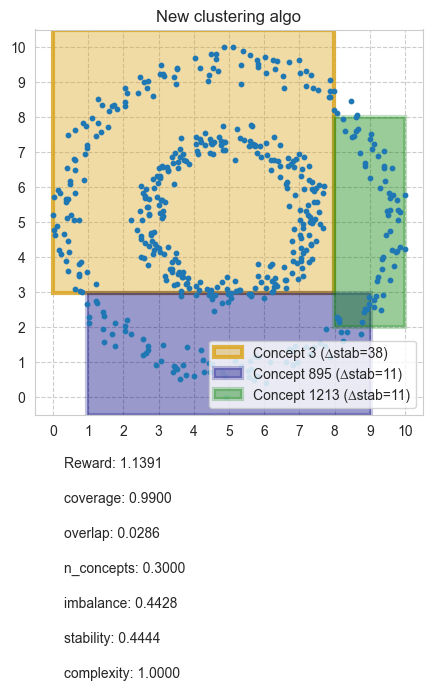

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

vlib.init_axis(ax, f"New clustering algo", linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)), grid_params=dict(zorder=0, linestyle='--'))

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
vlib.draw_clustering(ax, best_clustering, concepts_df)

reward, reward_details = clib.clustering_reward2(best_clustering, concepts_df, **reward_weights)
for i, (k, v) in enumerate([('Reward', reward)]+ list(reward_details.items())):
    ax.text(-1, linscale_y[0]-(i+2)*(linscale_y[1]-linscale_y[0]), f"{k}: {v:.4f}")


ax.legend(loc='lower right')
#fig.savefig('../figures/pipe_step4_circlesdata.pdf')
plt.show()

# Visualisations

## Step 1. Get the data

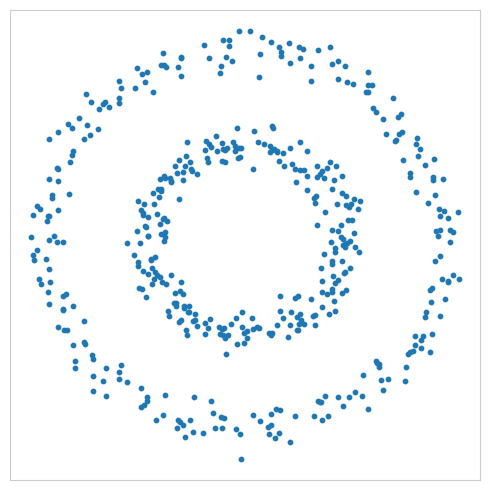

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))

vlib.init_axis(
    ax, None, #f"New clustering algo",
    [],[],[],[], #linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)),
    grid_params=dict(zorder=0, linestyle='--')
)

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
#vlib.draw_clustering(ax, best_clustering, concepts_df)

#ax.legend(loc='lower right')
fig.tight_layout()
fig.savefig('../figures/pipe_step1_circlesdata.pdf')
plt.show()

## Step 2. Init PS

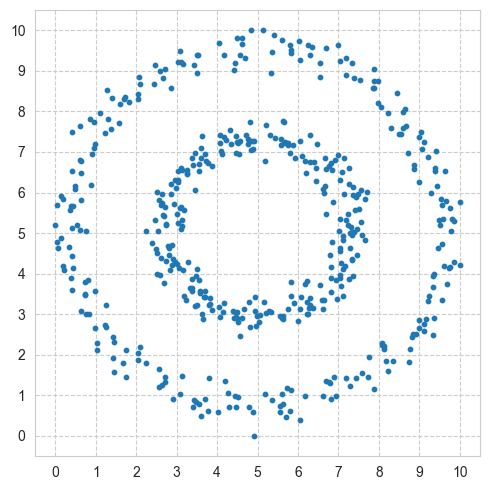

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))

vlib.init_axis(
    ax, None, #f"New clustering algo",
    linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)),
    grid_params=dict(zorder=0, linestyle='--')
)

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
#vlib.draw_clustering(ax, best_clustering, concepts_df)

#ax.legend(loc='lower right')
fig.tight_layout()
fig.savefig('../figures/pipe_step2_circlesdata.pdf')
plt.show()

## Step 3. Mine stable concepts

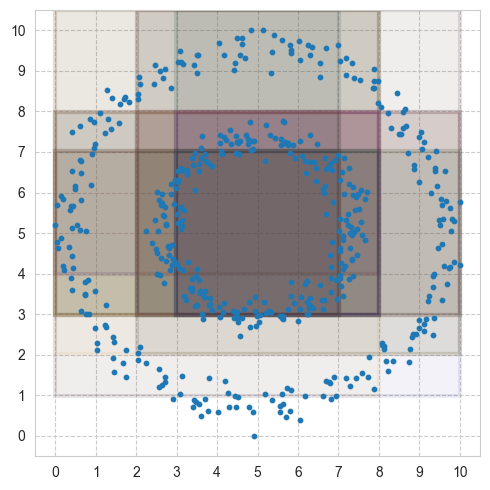

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

vlib.init_axis(
    ax, None, #f"New clustering algo",
    linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)),
    grid_params=dict(zorder=0, linestyle='--')
)

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
vlib.draw_clustering(ax, concepts_df.sort_values('delta_stability', ascending=False).index[:30][::-1], concepts_df, face_alpha=0.05, edge_alpha_factor=0.1,
                     cluster_colors=['goldenrod', 'navy', 'green', 'purple'])

#ax.legend(loc='lower right')
fig.tight_layout()
fig.savefig('../figures/pipe_step3_circlesdata.pdf')
plt.show()

## Step 4. Choose a clustering

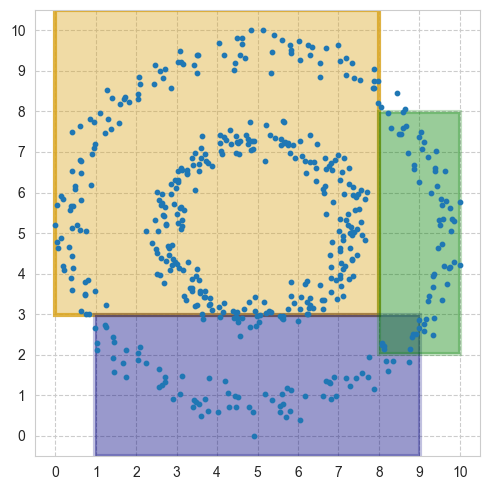

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))

vlib.init_axis(
    ax, None, #f"New clustering algo",
    linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)),
    grid_params=dict(zorder=0, linestyle='--')
)

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
vlib.draw_clustering(
    ax, best_clustering, concepts_df, face_alpha=0.4, edge_alpha_factor=1, cluster_colors=['goldenrod', 'navy', 'green', 'purple'])

#ax.legend(loc='lower right')
fig.tight_layout()
fig.savefig('../figures/pipe_step4_circlesdata.pdf')
plt.show()